In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_06 import *

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner()

run.fit(3, learn)

In [7]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [8]:
@annealer
def sched_lin(start, end, pos): return start + (end - start) * pos

In [9]:
sched = sched_lin(1,2)

In [10]:
sched(0.3)

1.3

In [11]:
@annealer
def sched_no(start, end, pos): return start 
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi * (1 - pos))) * (end - start) / 2
@annealer
def sched_exp(start, end, pos): return start * (end / start) ** pos

In [12]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [13]:
sched = sched_cos(1.,2)

In [14]:
sched(0.1), sched(0.3), sched(0.5), sched(0.7), sched(0.9)

(1.0244717418524232,
 1.2061073738537635,
 1.5,
 1.7938926261462365,
 1.9755282581475768)

In [15]:
sched = cos_1cycle_anneal(1, 1.5, 2)

In [16]:
sched[0](0.1)

1.0122358709262116

In [17]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

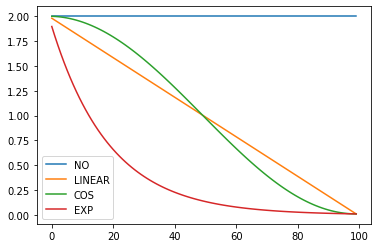

In [18]:
annealings = 'NO LINEAR COS EXP'.split()
fcts = [sched_no, sched_lin, sched_cos, sched_exp]

x = torch.arange(0, 100)
y = torch.linspace(0.01, 1, 100)

for fct, name in zip(fcts, annealings):
    sched = fct(2,1e-2)
    
    plt.plot(x, [sched(o) for o in y], label=name)
plt.legend();

In [19]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = tensor([0] + listify(pcts))
    assert all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner
    

In [20]:
scheds = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [21]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub('Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

In [22]:
class TrainEvalCallback(Callback):
        def begin_fit(self):
            self.run.n_epochs = 0.
            self.run.n_iter = 0
            
        def after_batch(self):
            if not self.in_train: return
            self.run.n_epochs += 1 / self.iters
            self.run.n_iter += 1
            
        def begin_epoch(self):
            self.run.n_epochs = self.epoch
            self.run.in_train = True
            self.model.train()
            
        def begin_validate(self):
            self.run.in_train = False
            self.model.eval()

In [23]:
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [24]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.stop, self.in_train = False, False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.cbs = [TrainEvalCallback()] + cbs

    @property
    def model(self): return self.learn.model
    @property
    def opt(self): return self.learn.opt
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self): return self.learn.data

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(self.epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')

        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.learn = None

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

In [25]:
class TestCallback(Callback):
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [26]:
learn = create_learner(get_model, loss_func, data)

In [27]:
run = Runner(cb_funcs=TestCallback)

In [28]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


In [29]:
AvgStats??

Init signature: AvgStats(metrics, in_train)
Docstring:      <no docstring>
Source:        
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train

    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o / self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ''
        return f'{"train" if self.in_train else "valid"}: {self.avg_stats}'

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn
File:           ~/repo/fastai-course-v3/nbs/dl2/selfmade/exp/nb_04.py
Type:           type
Subclasses:     


In [30]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o / self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ''
        return f'{"train" if self.in_train else "valid"}: {self.avg_stats}'
    
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

In [31]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [32]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses) - skip_last])
    
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
        
    def plot_lr_find(self, pgid=-1, skip_last=0):
        lrs = self.lrs[pgid]
#         losses = [o.item() for o in self.losses] # doesnt seem necessary; transforms the losses from a list of tensors into a list of numbers
        losses = self.losses
        n = len(losses) - skip_last
        
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [33]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def begin_batch(self):
        if self.in_train: self.set_param()
            
    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs / self.epochs)

In [34]:
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [35]:
learn = create_learner(get_model, loss_func, data)

In [36]:
run = Runner(cb_funcs=[Recorder, LR_Find])

In [37]:
run.fit(3, learn)

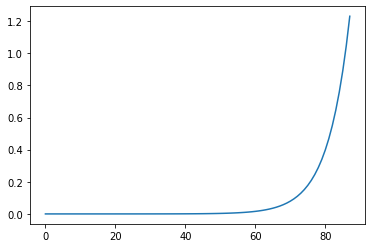

In [38]:
run.recorder.plot_lr()

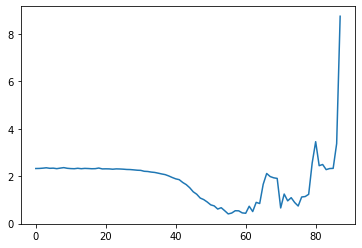

In [39]:
run.recorder.plot_loss()

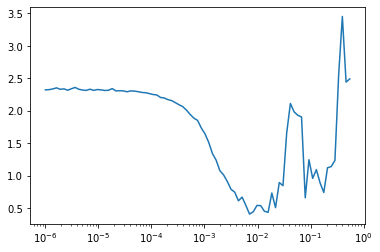

In [40]:
run.recorder.plot_lr_find(skip_last=5)

In [41]:
x_train.mean(), x_train.std()

(tensor(-9.9649e-10), tensor(1.0000))

In [42]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)

In [43]:
def mnist_resize(xb): return xb.view(-1, 1, 28, 28)
def flatten(xb): return xb.view(xb.shape[0], -1)

In [44]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, stride=2, padding=2), nn.ReLU(), # 14
        nn.Conv2d(8, 16, 3, stride=2, padding=1), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, stride=2, padding=1), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [45]:
model = get_cnn_model(data)

In [46]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [47]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [48]:
%time run.fit(1, learn)

train: [1.7564743489583334, tensor(0.3934)]
valid: [0.4739955078125, tensor(0.8666)]
CPU times: user 7.2 s, sys: 76.4 ms, total: 7.28 s
Wall time: 3.64 s


# Cuda

In [49]:
device = torch.device('cuda', 0)

In [50]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    
    def begin_fit(self): self.model.to(device)
    
    def begin_batch(self):
        self.run.xb, self.run.yb = self.run.xb.to(device), self.run.yb.to(device)

In [51]:
torch.cuda.set_device(device)

In [52]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.run.xb.cuda(), self.run.yb.cuda()

In [53]:
cbfs.append(CudaCallback)

In [54]:
model = get_cnn_model(data)

In [55]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [56]:
%time run.fit(3, learn)

train: [1.687718359375, tensor(0.4091, device='cuda:0')]
valid: [0.462986279296875, tensor(0.8607, device='cuda:0')]
train: [0.272407763671875, tensor(0.9164, device='cuda:0')]
valid: [0.2028370361328125, tensor(0.9308, device='cuda:0')]
train: [0.13935939127604166, tensor(0.9584, device='cuda:0')]
valid: [0.11983668212890625, tensor(0.9615, device='cuda:0')]
CPU times: user 3.94 s, sys: 564 ms, total: 4.5 s
Wall time: 3.95 s


# Refactoring

In [57]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2), nn.ReLU())

In [58]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.run.xb)

In [59]:
def view_tfm(*size):
    def _inner(xb): return xb.view(*((-1,) + size))
    
    return _inner

In [60]:
mnist_view = view_tfm(1,28,28)

In [61]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [62]:
cbfs

[__main__.Recorder,
 functools.partial(<class '__main__.AvgStatsCallback'>, <function accuracy at 0x7f28d3f02b80>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f283e595700>)]

In [63]:
nfs = [8, 16, 32, 32]

In [64]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3) for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [65]:
def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [66]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    
    return learn, Runner(cb_funcs=listify(cbs))

In [67]:
model = get_cnn_model(data, nfs)

In [68]:
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [69]:
model # before AdatpiveAvgPool the output layer is bs 2, 2, 32; after AdaptiveAvgPool the output layer is bs, 1, 1, 32

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [70]:
run.fit(3, learn)

train: [2.2172856770833334, tensor(0.2010, device='cuda:0')]
valid: [2.0202359375, tensor(0.3214, device='cuda:0')]
train: [0.7456681640625, tensor(0.7665, device='cuda:0')]
valid: [0.516432373046875, tensor(0.8487, device='cuda:0')]
train: [0.22705965169270834, tensor(0.9309, device='cuda:0')]
valid: [0.17932972412109374, tensor(0.9451, device='cuda:0')]


# Hooks

In [71]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        
        return x
            
    def __iter__(self): return iter(self.layers)

In [72]:
cbfs

[__main__.Recorder,
 functools.partial(<class '__main__.AvgStatsCallback'>, <function accuracy at 0x7f28d3f02b80>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f283e595700>)]

In [73]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [74]:
run.fit(2, learn)

train: [2.049358984375, tensor(0.2625, device='cuda:0')]
valid: [1.06588212890625, tensor(0.6860, device='cuda:0')]
train: [0.45085159505208333, tensor(0.8607, device='cuda:0')]
valid: [0.33865888671875, tensor(0.8994, device='cuda:0')]


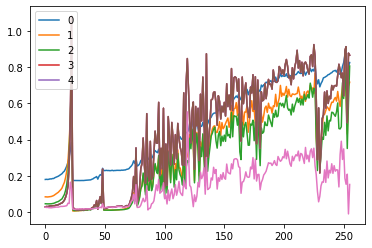

In [75]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

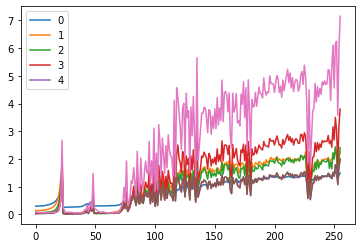

In [76]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

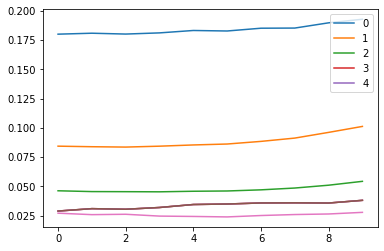

In [77]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

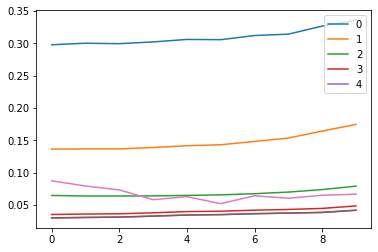

In [78]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

## Pytorch hooks

In [79]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [80]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [81]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [82]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [83]:
run.fit(1, learn)

train: [2.1306963541666666, tensor(0.2326, device='cuda:0')]
valid: [1.07534482421875, tensor(0.6634, device='cuda:0')]


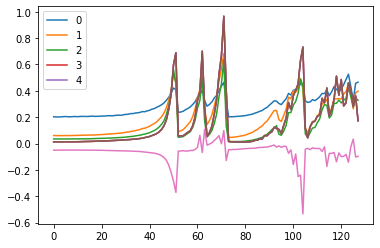

In [84]:
for l in act_means: plt.plot(l)
plt.legend(range(5))

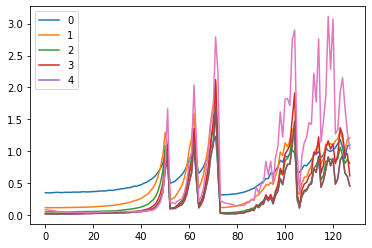

In [85]:
for l in act_stds: plt.plot(l)
plt.legend(range(5))

# Hook class

In [86]:
def children(m): return list(m.children())

In [87]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [88]:
class Hook():
    def __init__(self, layer, f): self.hook = layer.register_forward_hook(partial(f, self))
    def __del__(self): self.remove()
    def remove(self): self.hook.remove()

In [89]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.6, cbs=cbfs)

In [90]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [91]:
run.fit(1, learn)

train: [1.5260842447916667, tensor(0.4780, device='cuda:0')]
valid: [1.1786576171875, tensor(0.7443, device='cuda:0')]


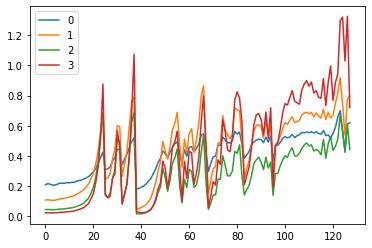

In [92]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

# A Hooks class

In [93]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for o,m in zip(self.items, idx) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, k): self.items[i] = k
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self.items)} items)\n{self.items[:10]}'
        if len(self.items) > 10: res = res[:-1] + '...]'
        return res

In [94]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [95]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [96]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [97]:
abc = ListContainer(range(10))

In [98]:
abc[[3, 1]]

[3, 1]

In [99]:
from torch.nn import init

In [100]:
class Hooks(ListContainer):
    def __init__(self, model, f): super().__init__([Hook(layer, f) for layer in model])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove
        super().__delitem__(i)
    
    def remove(self):
        for h in self: h.remove()

In [101]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [102]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f283e561a30>, <__main__.Hook object at 0x7f283e5614f0>, <__main__.Hook object at 0x7f283e561130>, <__main__.Hook object at 0x7f283e561250>, <__main__.Hook object at 0x7f283e561490>, <__main__.Hook object at 0x7f283e561370>, <__main__.Hook object at 0x7f283e561910>]

In [103]:
hooks.remove()

In [104]:
xb, yb = next(iter(data.train_dl))
xb = mnist_resize(xb).cuda()

In [105]:
xb.mean(), xb.std()

(tensor(0.0017, device='cuda:0'), tensor(1.0021, device='cuda:0'))

In [106]:
p = model[0](xb)
p.mean(), p.std()

(tensor(0.1782, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3581, device='cuda:0', grad_fn=<StdBackward0>))

In [107]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [108]:
p = model[0](xb)
p.mean(), p.std()

(tensor(0.4363, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.7382, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.4978393229166667, tensor(0.4711, device='cuda:0')]
valid: [0.5112216796875, tensor(0.8307, device='cuda:0')]
train: [0.22383448893229166, tensor(0.9322, device='cuda:0')]
valid: [0.436658837890625, tensor(0.8559, device='cuda:0')]


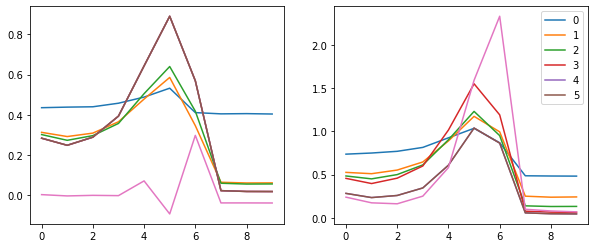

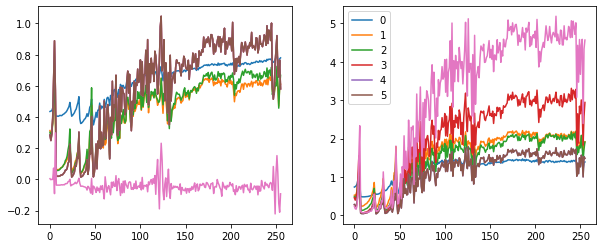

In [109]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

In [110]:
def append_stats(hooks, mod, inp, outp):
    if not hasattr(hooks, 'stats'): hooks.stats = ([], [], [])
    means, stds, hists = hooks.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

In [111]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [112]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [113]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.7019524739583334, tensor(0.4195, device='cuda:0')]
valid: [0.6170142578125, tensor(0.7866, device='cuda:0')]


In [114]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

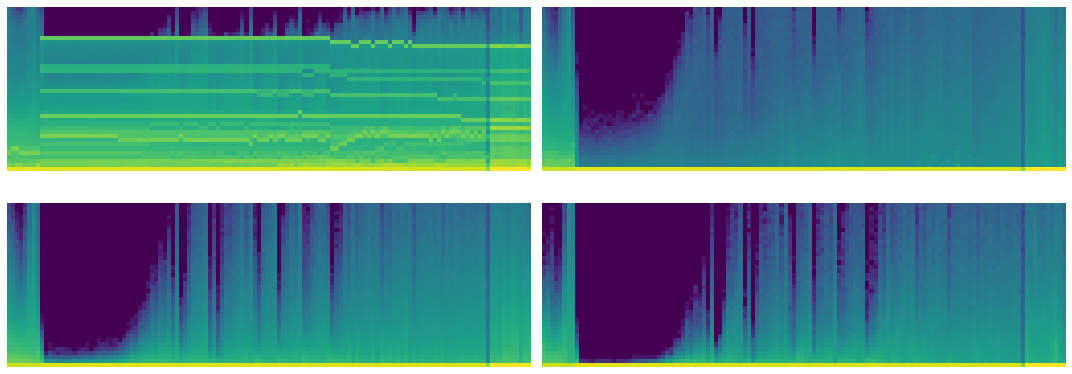

In [115]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [116]:
def get_min(h): 
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0) / h1.sum(0)

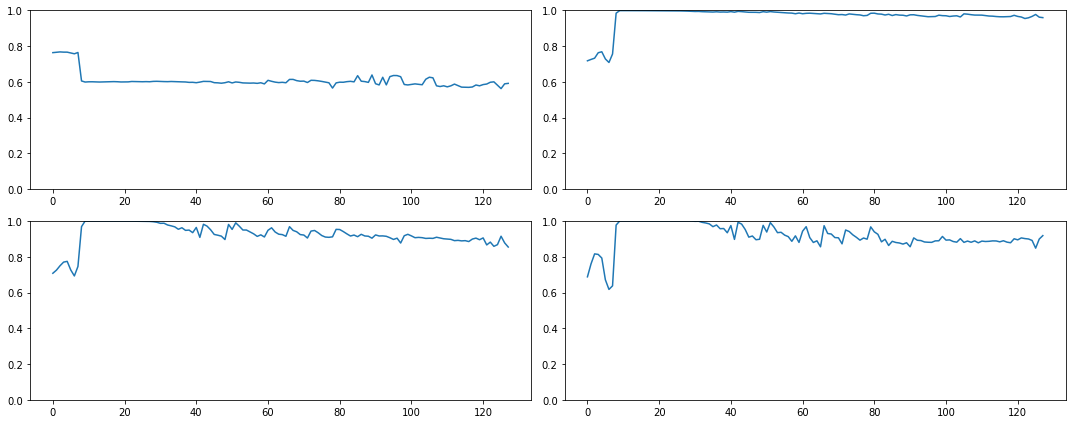

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Generalized ReLU

In [118]:
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [119]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i == 0 else 3, **kwargs) for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [120]:
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2), GeneralReLu(**kwargs))

In [121]:
class GeneralReLu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [122]:
def init_cnn(model, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in model:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1) # a is about the negative slope of the rectifier 
            l[0].bias.data.zero_()

In [123]:
def append_stats(hooks, mod, inp, outp):
    if not hasattr(hooks, 'stats'): hooks.stats = ([], [], [])
    means, stds, hists = hooks.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7))

In [124]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.4579673177083333, tensor(0.8540, device='cuda:0')]
valid: [0.155569189453125, tensor(0.9530, device='cuda:0')]


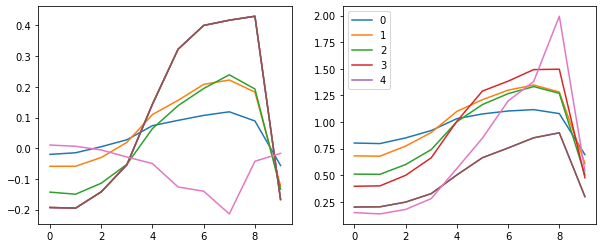

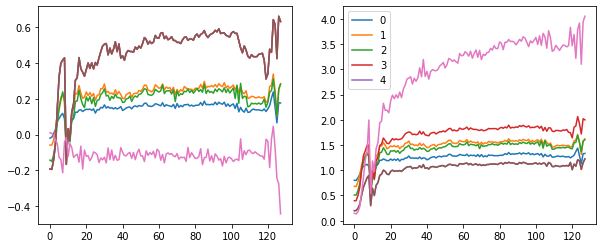

In [125]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in  hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

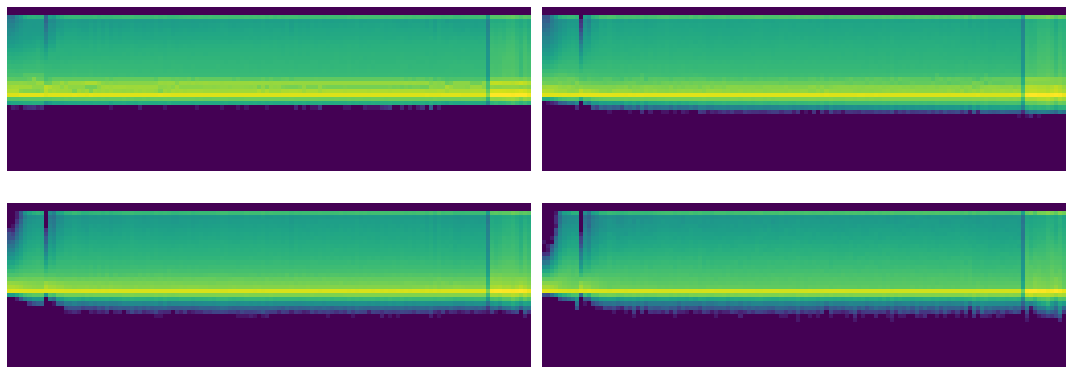

In [126]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [127]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0) / h1.sum(0)

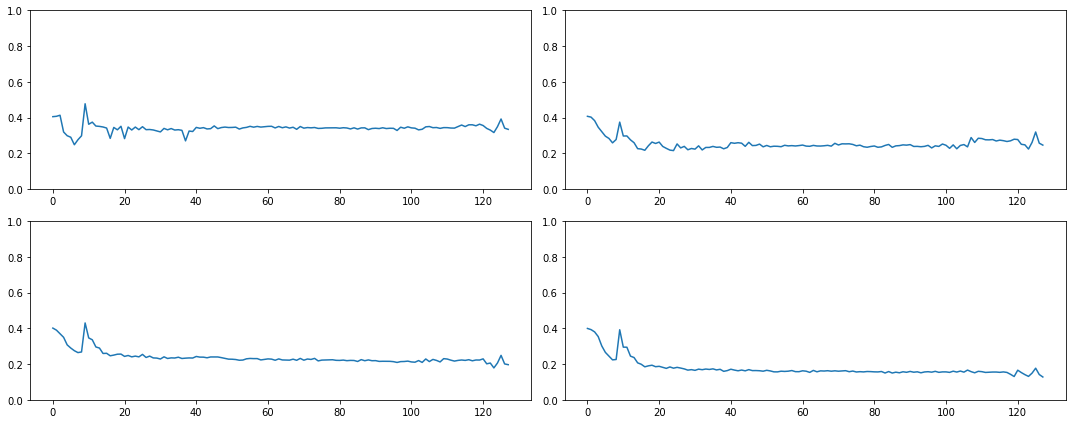

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
    plt.tight_layout()

In [129]:
get_runner??

Signature:
get_runner(
    model,
    data,
    lr=0.6,
    cbs=None,
    opt_func=None,
    loss_func=<function cross_entropy at 0x7f2883363700>,
)
Docstring: <no docstring>
Source:   
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    
    return learn, Runner(cb_funcs=listify(cbs))
File:      /tmp/ipykernel_14559/1797513399.py
Type:      function


In [130]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [131]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [136]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [137]:
run.fit(8, learn)

train: [0.9248916015625, tensor(0.7170, device='cuda:0')]
valid: [0.6338349609375, tensor(0.7974, device='cuda:0')]
train: [0.30396708984375, tensor(0.9077, device='cuda:0')]
valid: [0.2893469970703125, tensor(0.9129, device='cuda:0')]
train: [0.15726565755208333, tensor(0.9526, device='cuda:0')]
valid: [0.529414697265625, tensor(0.8503, device='cuda:0')]
train: [1.6005665364583332, tensor(0.4712, device='cuda:0')]
valid: [0.46848369140625, tensor(0.8553, device='cuda:0')]
train: [0.31278277994791664, tensor(0.9030, device='cuda:0')]
valid: [0.2405572021484375, tensor(0.9329, device='cuda:0')]
train: [0.14323758138020834, tensor(0.9566, device='cuda:0')]
valid: [0.18559287109375, tensor(0.9427, device='cuda:0')]
train: [0.10134275716145834, tensor(0.9690, device='cuda:0')]
valid: [0.0932917236328125, tensor(0.9713, device='cuda:0')]
train: [0.08541956380208333, tensor(0.9734, device='cuda:0')]
valid: [0.08920136108398438, tensor(0.9719, device='cuda:0')]


In [134]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)], uniform=True)

In [135]:
run.fit(8, learn)

train: [0.8591178385416667, tensor(0.7391, device='cuda:0')]
valid: [0.31060556640625, tensor(0.9067, device='cuda:0')]
train: [0.239260107421875, tensor(0.9267, device='cuda:0')]
valid: [0.15945228271484374, tensor(0.9523, device='cuda:0')]
train: [0.39480862630208335, tensor(0.8825, device='cuda:0')]
valid: [0.1372896240234375, tensor(0.9584, device='cuda:0')]
train: [0.12065062662760416, tensor(0.9629, device='cuda:0')]
valid: [0.2321528076171875, tensor(0.9218, device='cuda:0')]
train: [0.10836768391927083, tensor(0.9674, device='cuda:0')]
valid: [0.13764425048828124, tensor(0.9556, device='cuda:0')]
train: [0.06165165201822917, tensor(0.9806, device='cuda:0')]
valid: [0.0551097412109375, tensor(0.9816, device='cuda:0')]
train: [0.045853792317708336, tensor(0.9861, device='cuda:0')]
valid: [0.04996256408691406, tensor(0.9848, device='cuda:0')]
train: [0.03805305989583333, tensor(0.9885, device='cuda:0')]
valid: [0.049541357421875, tensor(0.9845, device='cuda:0')]


In [138]:
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [139]:
nb_auto_export()

<IPython.core.display.Javascript object>